# Unstructured
- https://unstructured.io/
- https://unstructured-io.github.io/unstructured/index.html
- https://docs.unstructured.io/api-reference/api-services/python-sdk


## Setup

In [3]:
%%capture
%pip install "unstructured[all-docs]" unstructured-client watermark

In [4]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [5]:
from IPython.display import JSON

import json

from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import dict_to_elements, elements_to_json

In [6]:
%load_ext watermark

In [7]:
import unstructured

In [8]:
%watermark --iversions

json               : 2.0.9
unstructured_client: 0.25.8
unstructured       : 0.15.12



## Initial exploration ( extract elements)

In [9]:
import unstructured.partition

help(unstructured.partition)

Help on package unstructured.partition in unstructured:

NAME
    unstructured.partition

PACKAGE CONTENTS
    api
    auto
    common
    csv
    doc
    docx
    email
    epub
    html (package)
    image
    json
    lang
    md
    model_init
    msg
    odt
    org
    pdf
    pdf_image (package)
    ppt
    pptx
    rst
    rtf
    strategies
    text
    text_type
    tsv
    utils (package)
    xlsx
    xml

FILE
    /home/ameer/Kaleidoo/.venv/lib/python3.10/site-packages/unstructured/partition/__init__.py




In [13]:
from unstructured.partition.pdf import partition_pdf

# Specify the path to your PDF file
filename = "/home/ameer/Kaleidoo/Data/Text-Data/pdf/Kaleidoo-Research-Phase.pdf"
# Call the partition_pdf function
# Returns a List[Element] present in the pages of the parsed pdf document
elements = partition_pdf(filename)

# Now, elements is a list of all elements present in the pages of the parsed pdf document

In [14]:
elements

In [24]:
len(elements)

118

In [16]:
from langdetect import detect, detect_langs, LangDetectException
from paths import * 

In [17]:
def refine_pdf_data(data):
    text = data.get("text", "")
    
    # Try to detect language if text is not empty or too short
    if len(text.strip()) > 5:  # Arbitrarily set threshold for minimum text length
        try:
            lang = detect_langs(text)[0].lang
        except LangDetectException:
            lang = 'unknown'  # Default to 'unknown' if detection fails
    else:
        lang = 'unknown'  # Default for short or empty texts
    
    refined = {
        "text": text,
        "metadata": {
            "offset": f"page{data['metadata'].get('page_number', '')}",
            "ref": f"{data['metadata'].get('file_directory', '')}/{data['metadata'].get('filename', '')}",
            "lang": lang,
            "filetype": data['metadata'].get('filetype', 'pdf')
        }
    }
    
    return refined


In [23]:
element_dict = [el.to_dict() for el in elements]
output = json.dumps(element_dict, indent=2)
refined = [ refine_pdf_data(data) for data in element_dict ]
with open(F'{DUMPTEXT}pdf.json', 'w') as f:
    json.dump(refined, f, indent=2)  # Use the file object 'f' instead of a string

In [22]:
unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

{'Title', 'NarrativeText', 'ListItem'}


##### We don't see `Image`, image information is not extracted as we expected, lets use different strategy.

### Image extraction from PDF
- Now let’s say that your PDF has tables and let’s say you want to preserve the image data. 
- You will have to specify the [strategy](https://unstructured-io.github.io/unstructured/best_practices/strategies.html) parameter as `hi_res`. This will use a combination of computer vision and Optical Character Recognition (OCR) to extract the tables and maintain the structure. 

> Note: For even better image extraction Unstructured offers an API that improves upon the existing open source models.

> Depending upon machine, you might face different module / library issues, these links might help
- https://stackoverflow.com/questions/59690698/modulenotfounderror-no-module-named-lzma-when-building-python-using-pyenv-on
- https://unstructured-io.github.io/unstructured/installation/full_installation.html

In [11]:
from unstructured.partition.pdf import partition_pdf

elements = partition_pdf(filename=filename,
                     strategy='hi_res',
           )

In [12]:
element_dict = [el.to_dict() for el in elements]

unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

{'Footer', 'Image', 'NarrativeText', 'ListItem', 'UncategorizedText', 'Title'}


In [13]:
images = [el for el in elements if el.category == "Image"]
print(images[5].text)
print(images[5].metadata.text_as_html)

aoe 2! qian? . Pin al a a ri Pa > . . . a ei id . . Pat’ . mA
None


In [14]:
images

In [15]:
len(images)

26

## Another way ( extract / display images + elements )

In [50]:
partition_pdf??

Signature:
partition_pdf(
    filename: 'Optional[str]' = None,
    file: 'Optional[IO[bytes]]' = None,
    include_page_breaks: 'bool' = False,
    strategy: 'str' = 'auto',
    infer_table_structure: 'bool' = False,
    ocr_languages: 'Optional[str]' = None,
    languages: 'Optional[list[str]]' = None,
    include_metadata: 'bool' = True,
    metadata_filename: 'Optional[str]' = None,
    metadata_last_modified: 'Optional[str]' = None,
    chunking_strategy: 'Optional[str]' = None,
    hi_res_model_name: 'Optional[str]' = None,
    extract_images_in_pdf: 'bool' = False,
    extract_image_block_types: 'Optional[list[str]]' = None,
    extract_image_block_output_dir: 'Optional[str]' = None,
    extract_image_block_to_payload: 'bool' = False,
    date_from_file_object: 'bool' = False,
    starting_page_number: 'int' = 1,
    extract_forms: 'bool' = False,
    form_extraction_skip_tables: 'bool' = True,
    **kwargs: 'Any',
) -> 'list[Element]'
Docstring:
Parses a pdf document into a lis

In [16]:
# Get elements
path = "images"
raw_pdf_elements = partition_pdf(filename=filename,
                                 # Unstructured first finds embedded image blocks
                                 # Only applicable if `strategy=hi_res`
                                 extract_images_in_pdf=True,
                                 strategy = "hi_res",
                                 infer_table_structure=True,
                                 # Only applicable if `strategy=hi_res`
                                 extract_image_block_output_dir = path,
                                 )

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
element_dict = [el.to_dict() for el in raw_pdf_elements]

unique_types = set()

for item in element_dict:
    unique_types.add(item['type'])

print(unique_types)

{'Footer', 'Image', 'NarrativeText', 'ListItem', 'UncategorizedText', 'Title'}


In [18]:
images = [el for el in raw_pdf_elements if el.category == "Image"]

print(images[5].text)
print(images[5].metadata.text_as_html)

aoe 2! qian? . Pin al a a ri Pa > . . . a ei id . . Pat’ . mA
None


### Let's display the images extracted

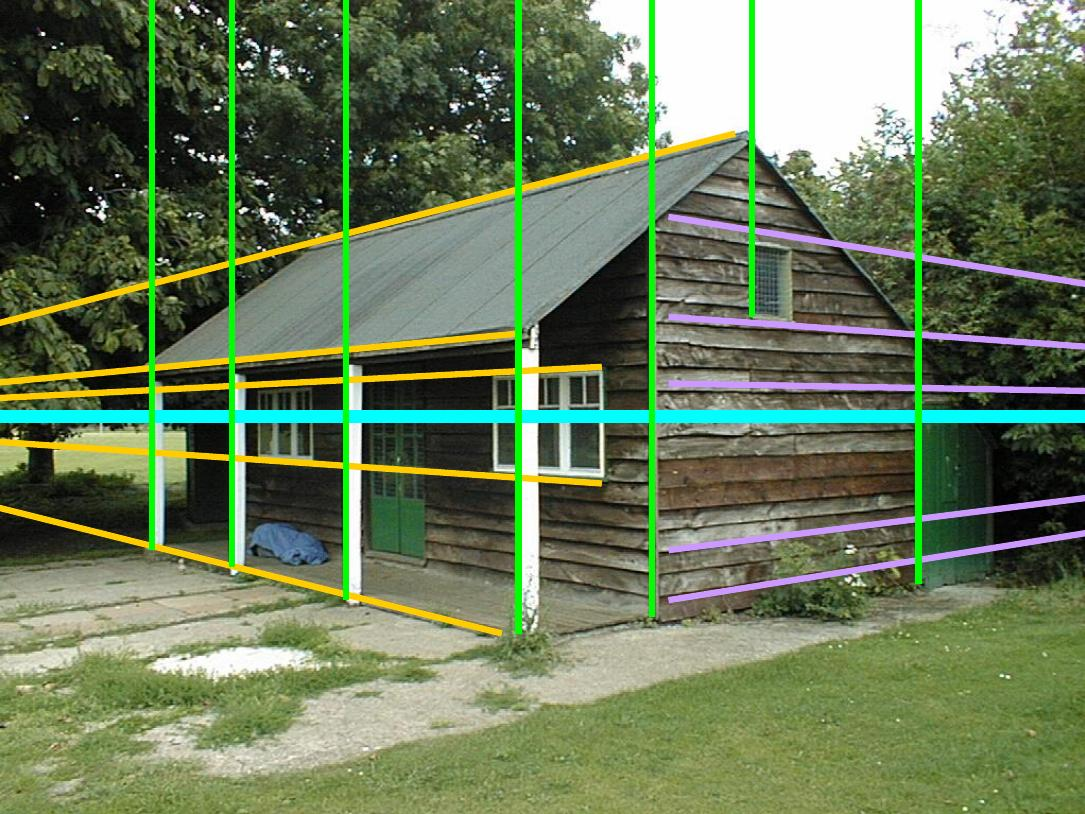

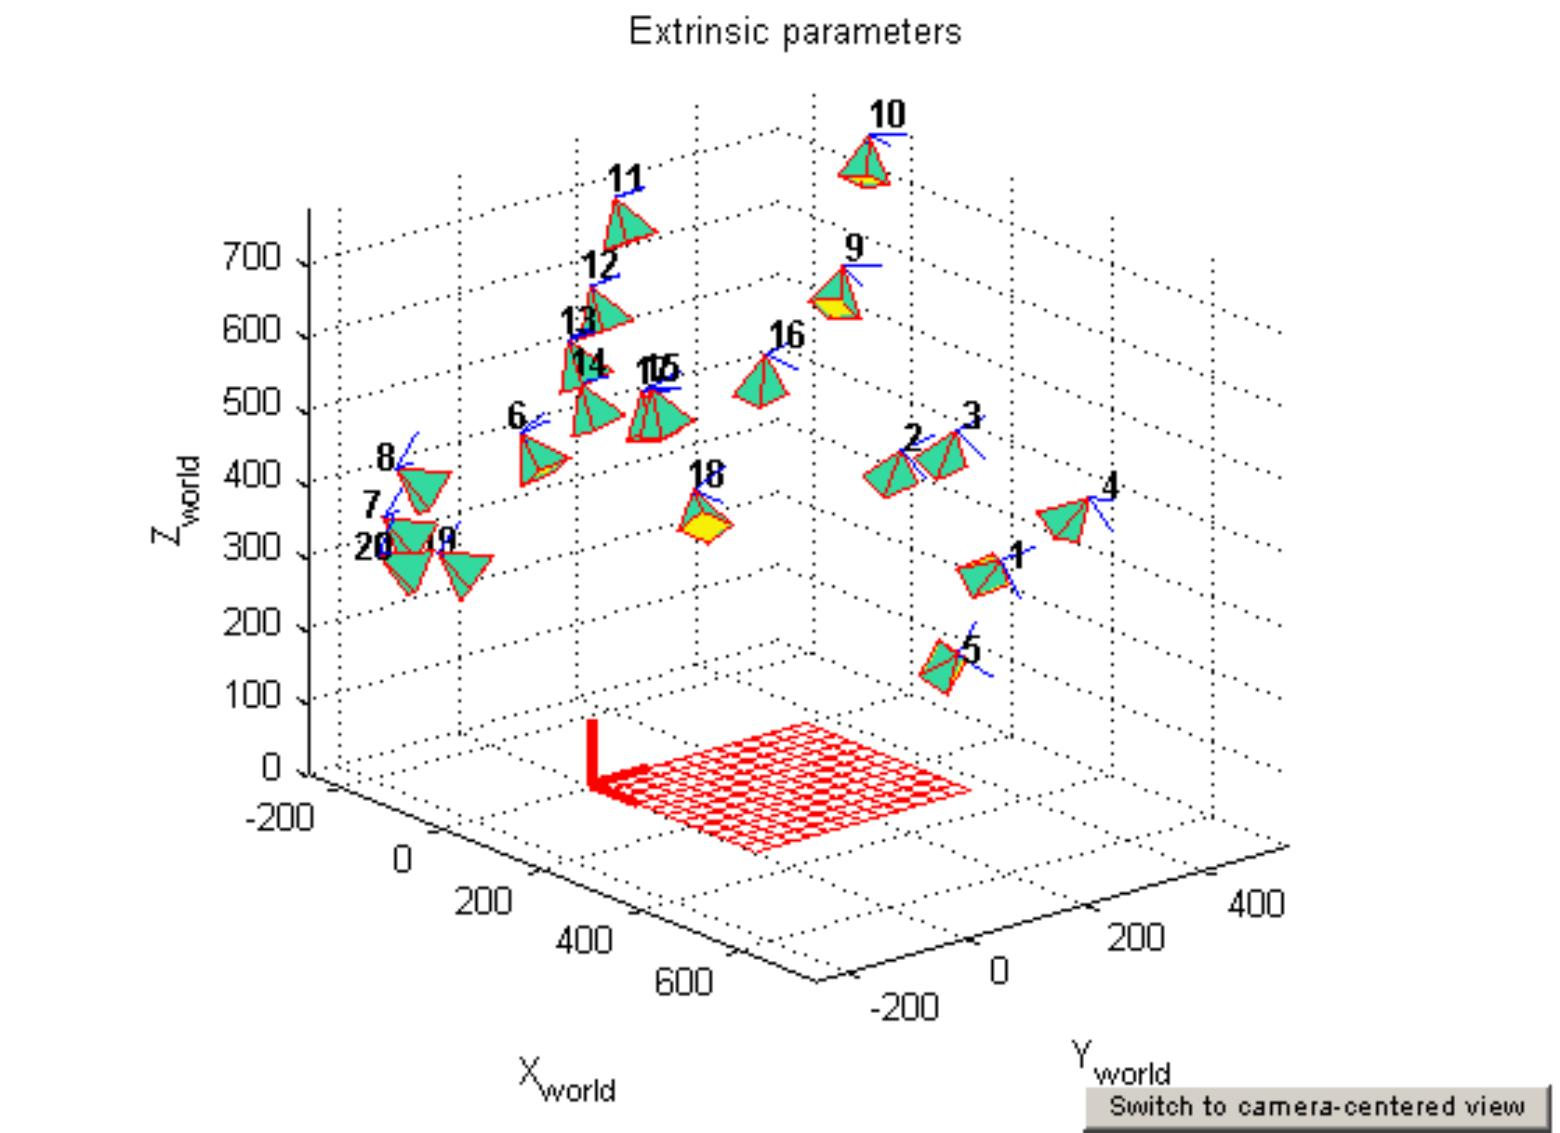

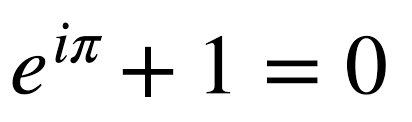

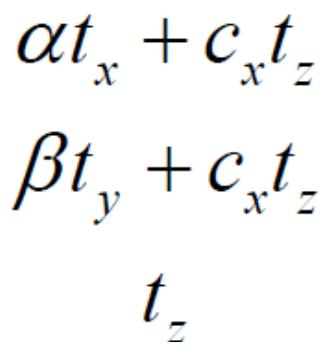

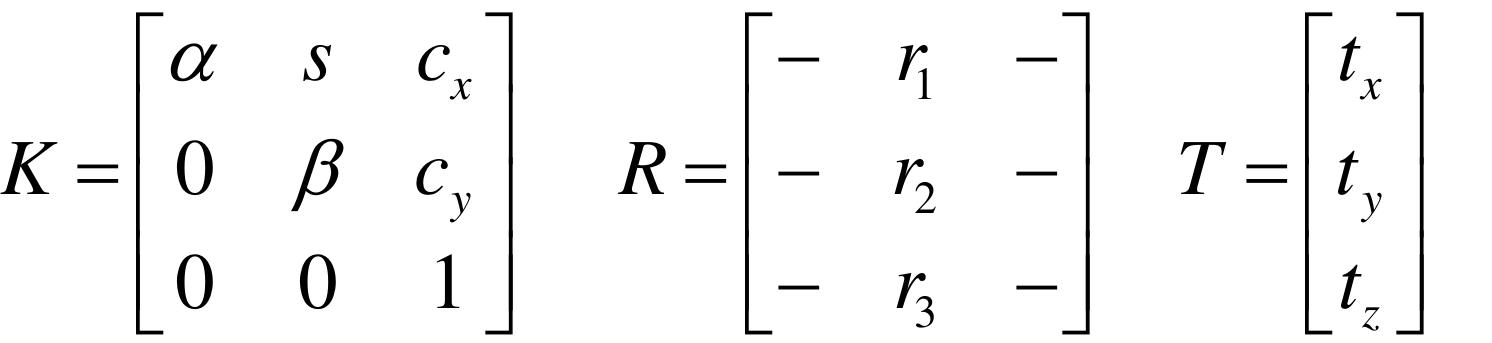

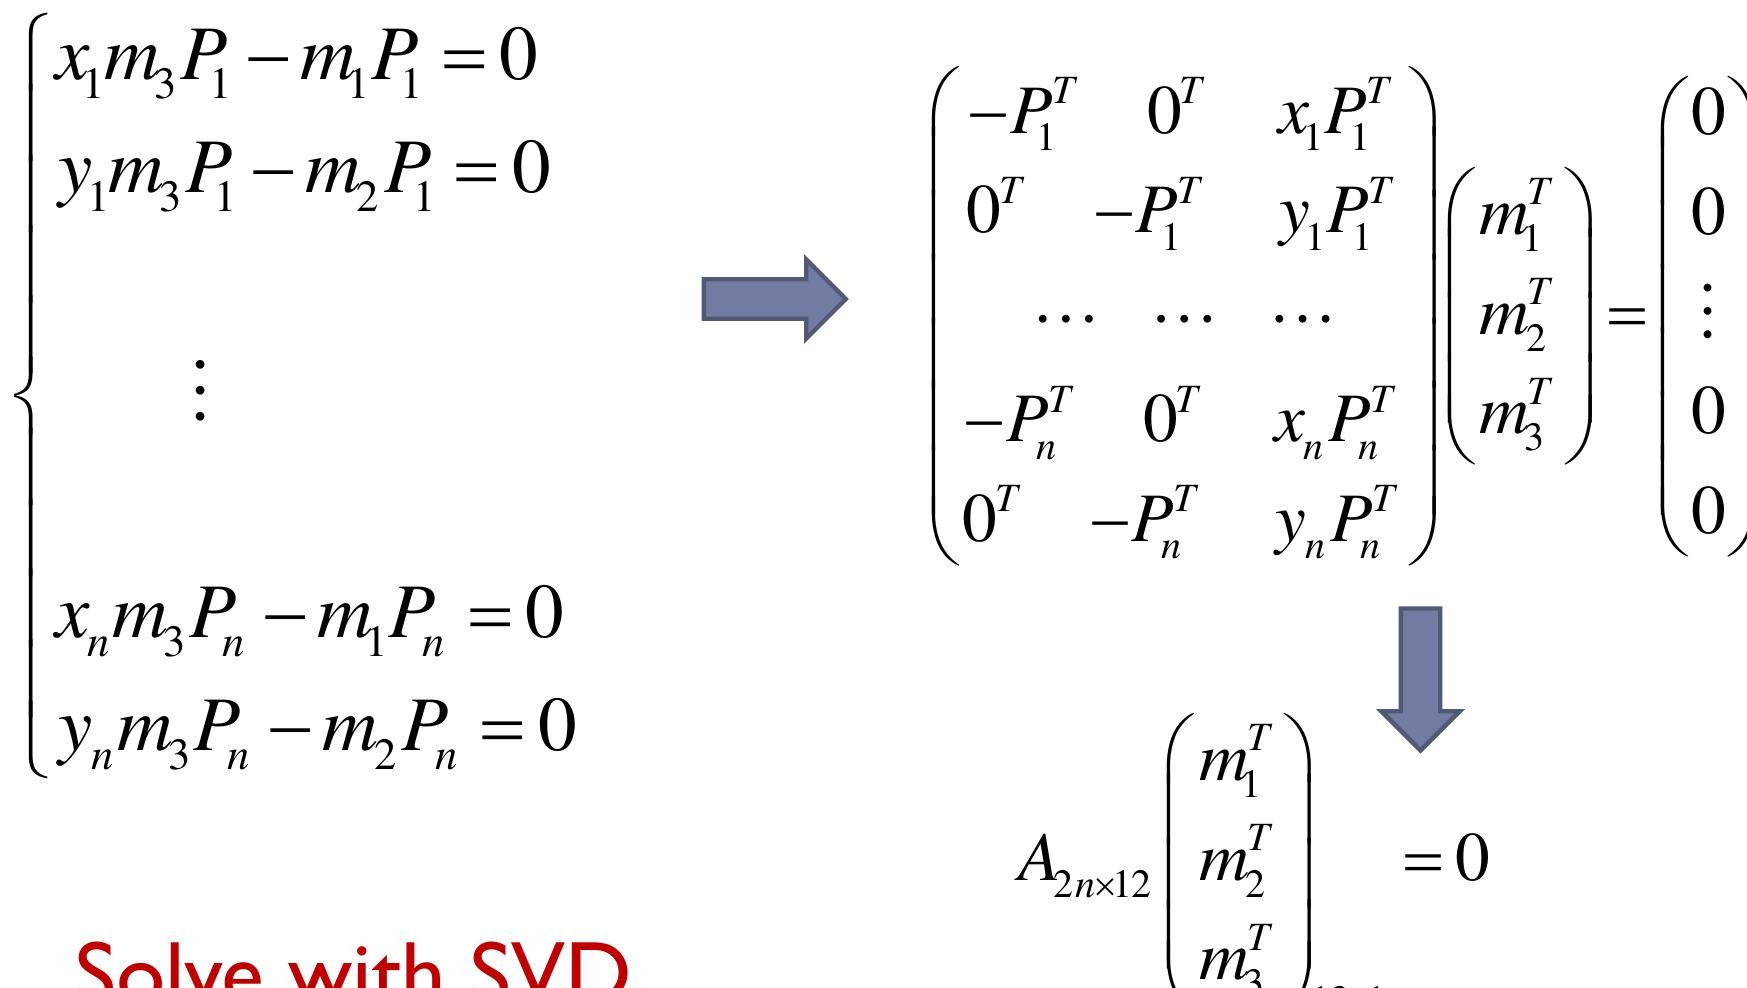

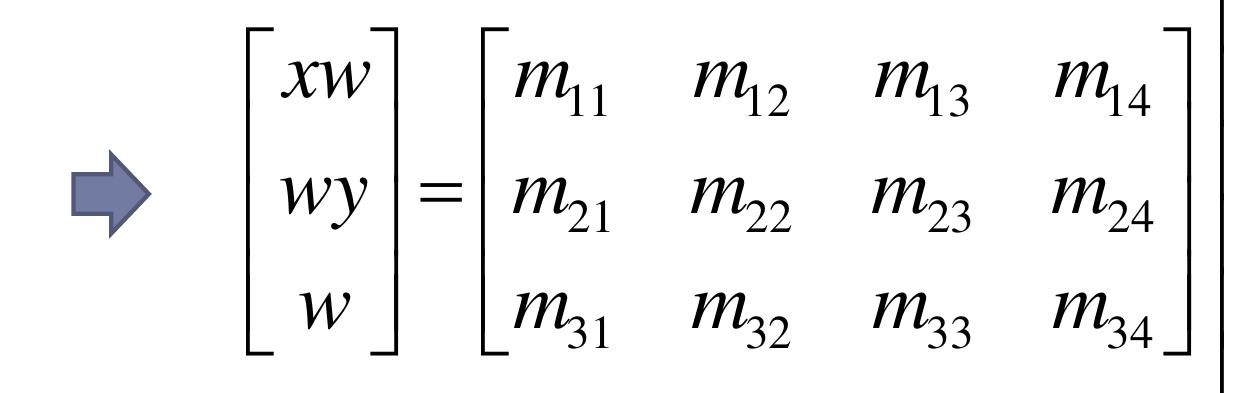

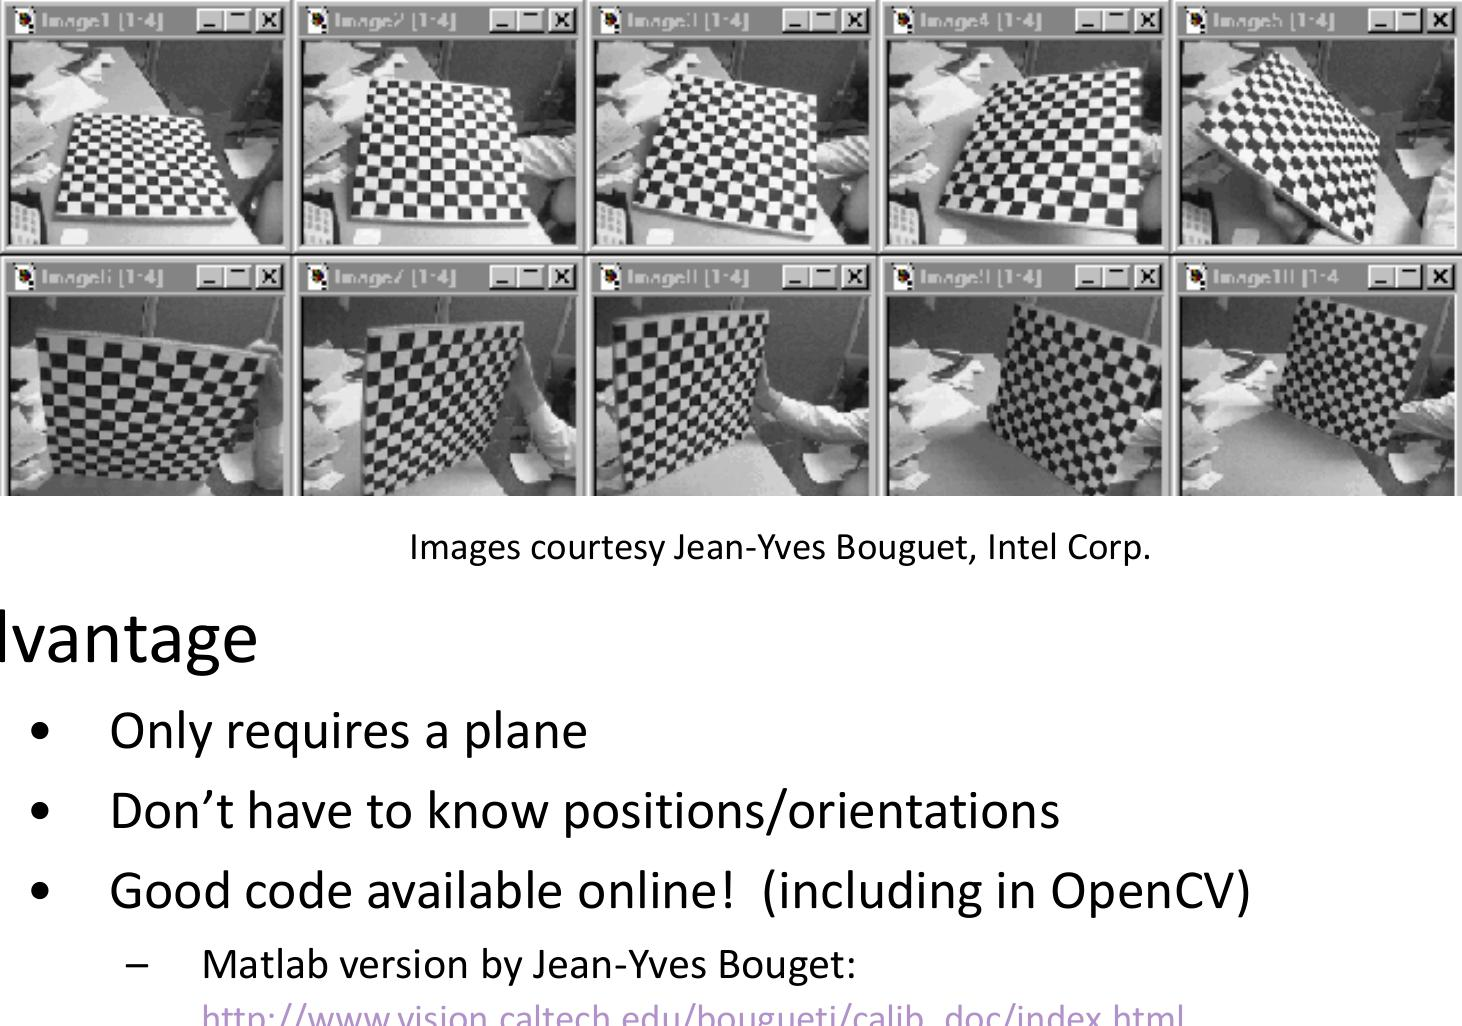

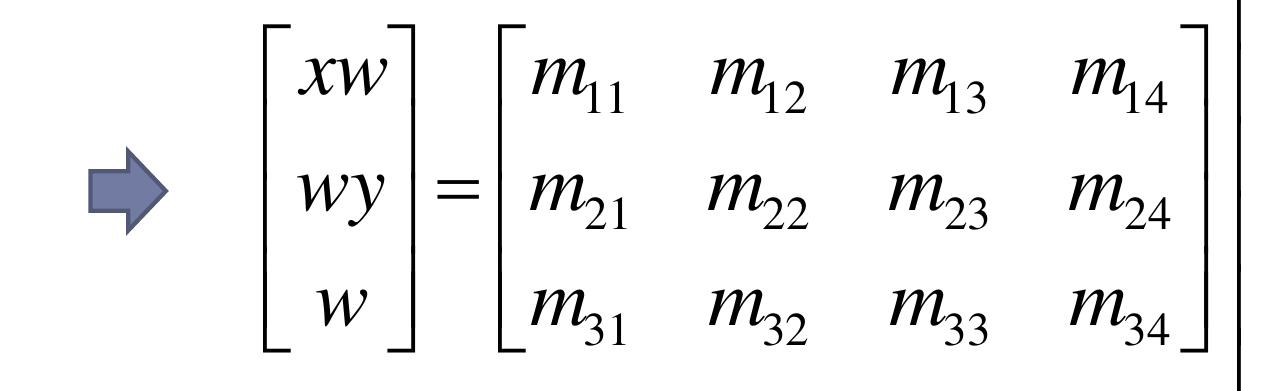

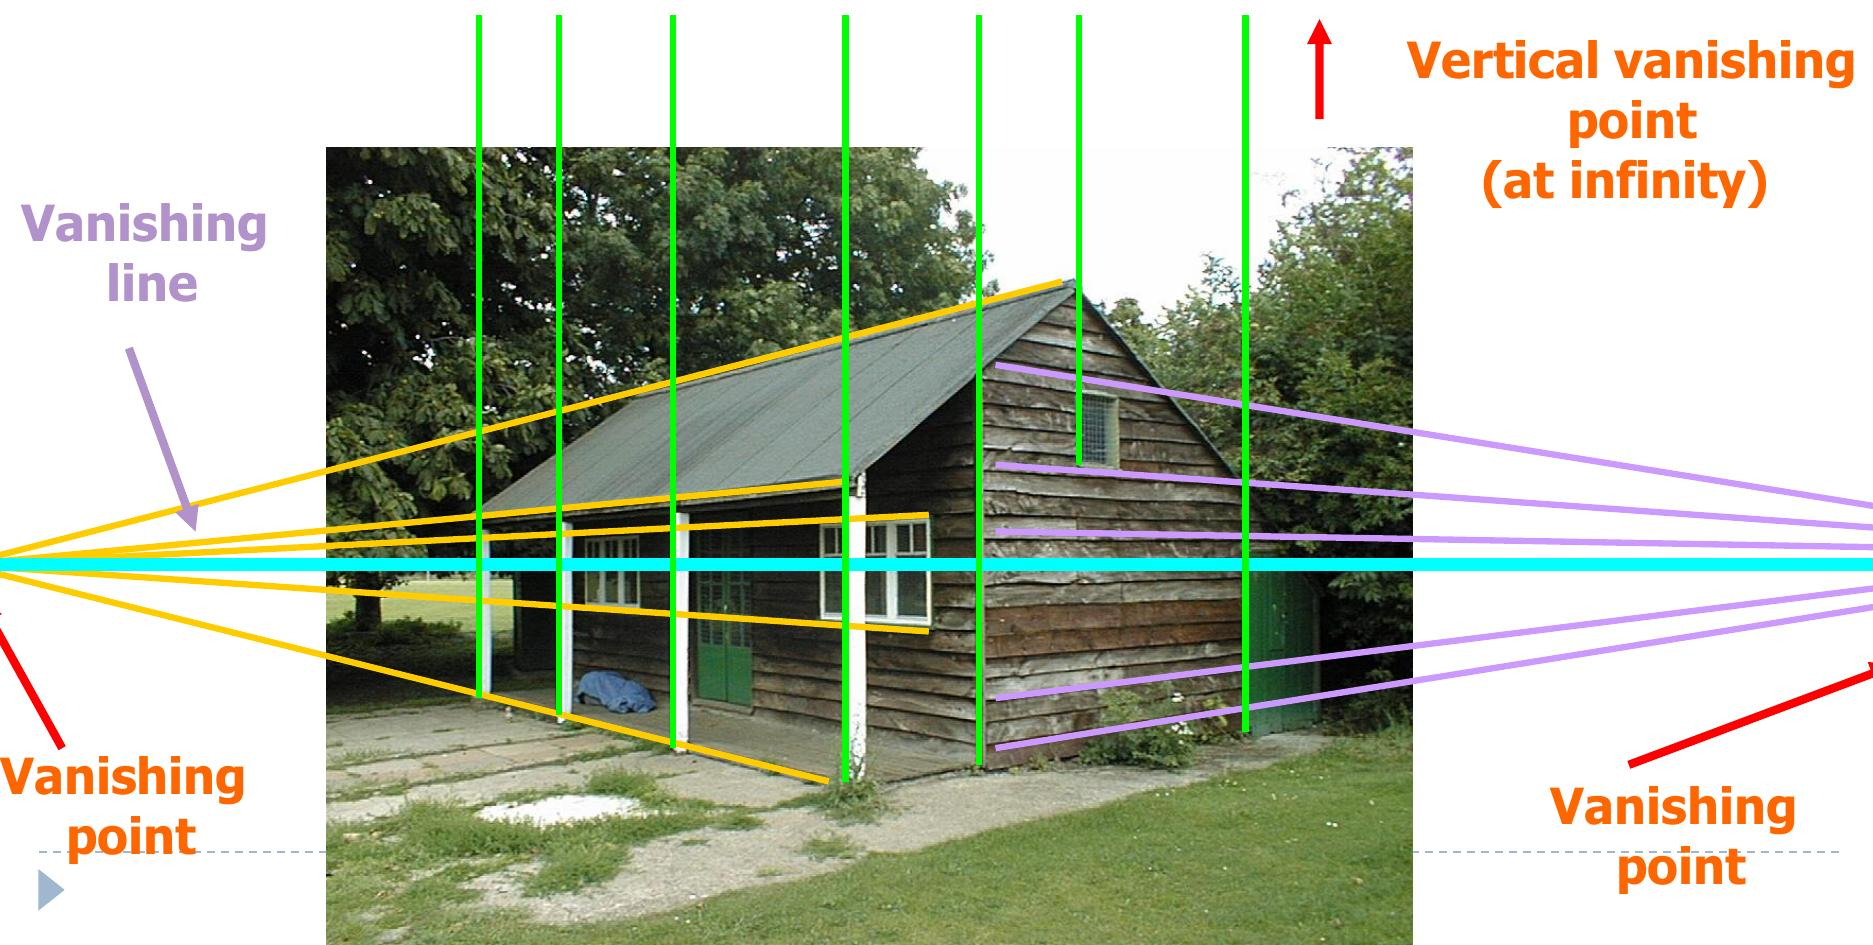

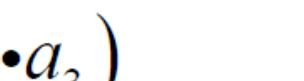

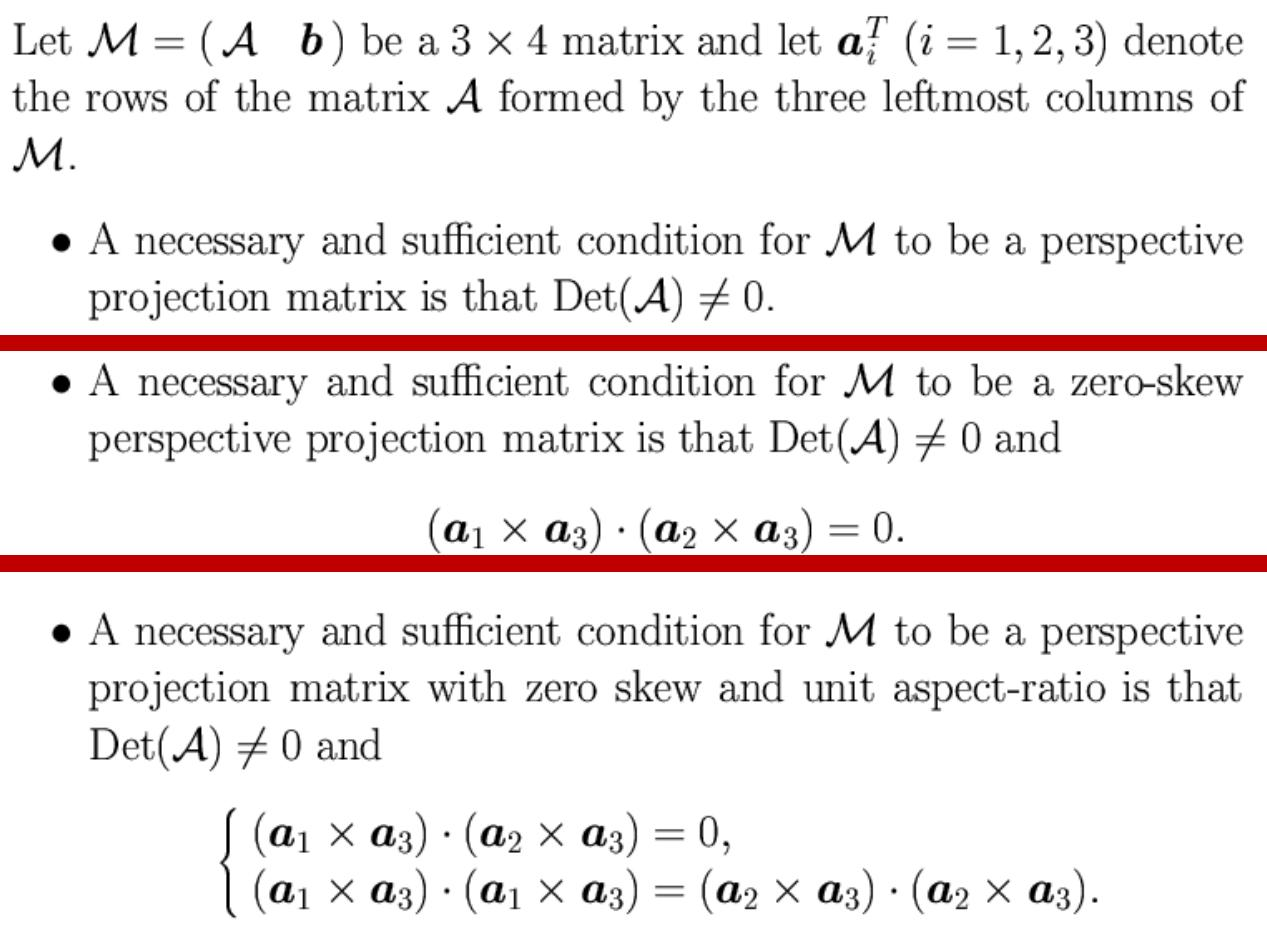

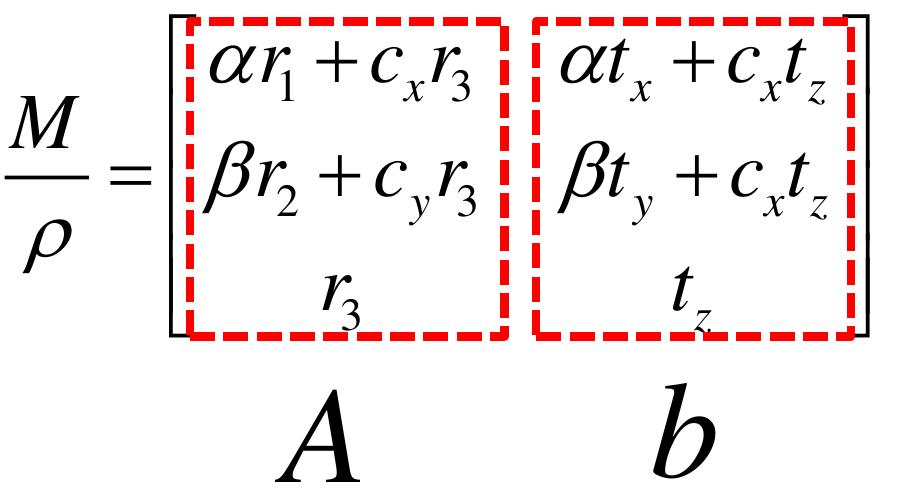

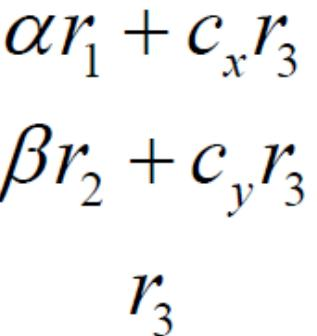

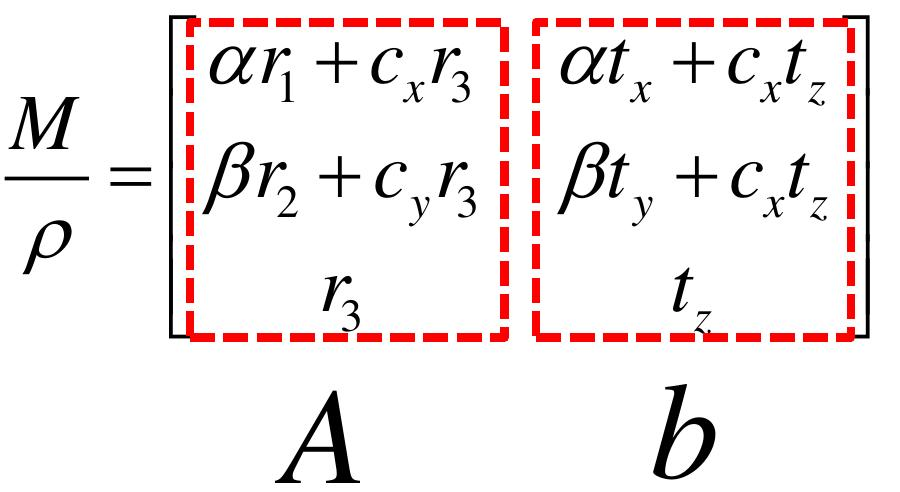

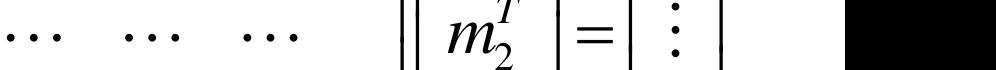

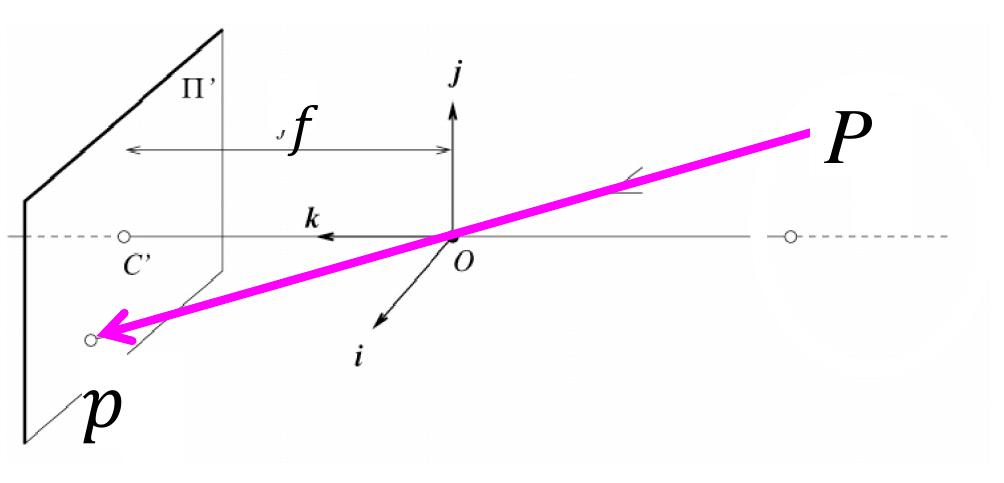

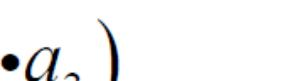

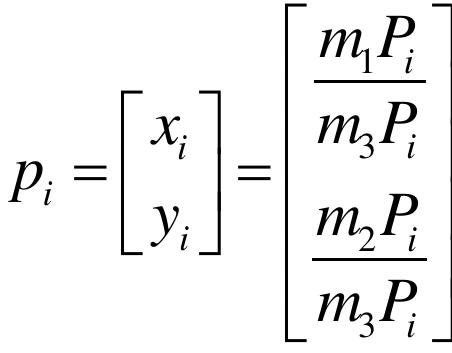

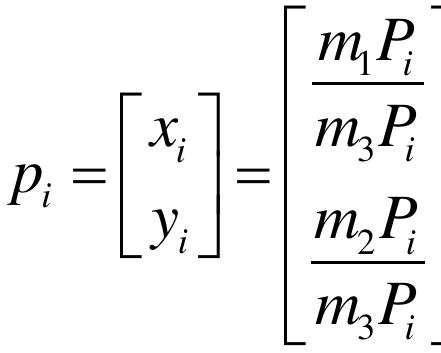

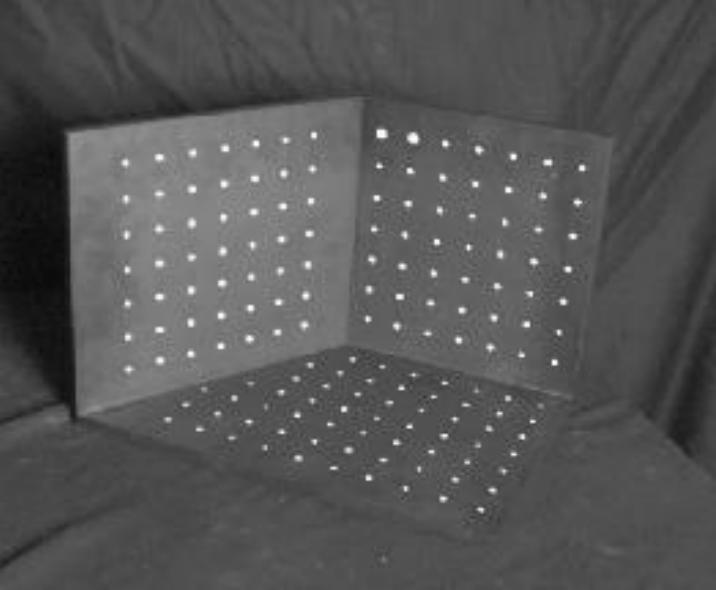

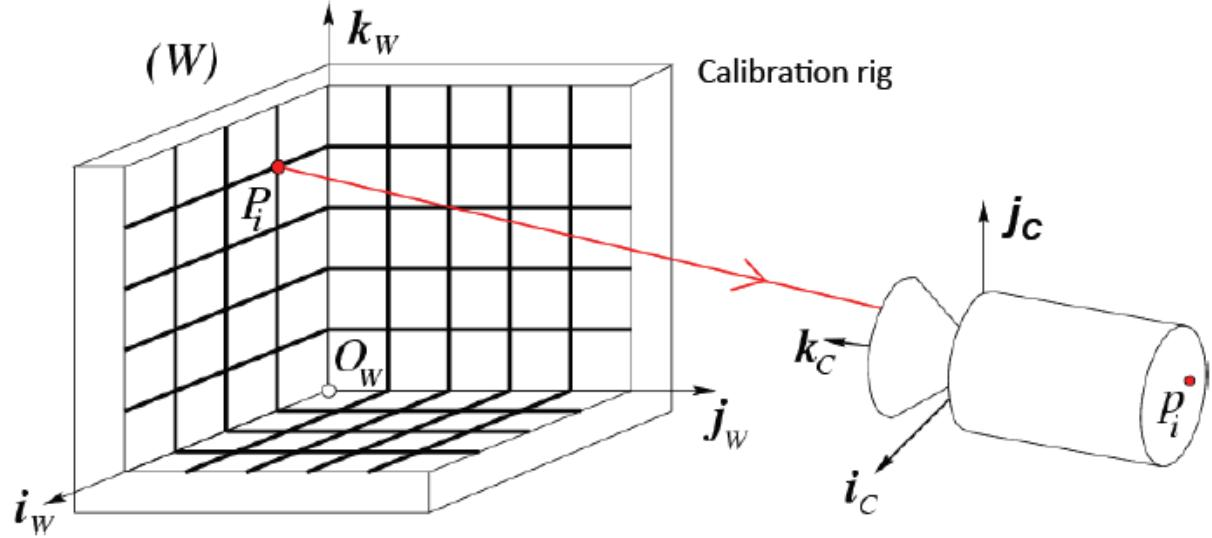

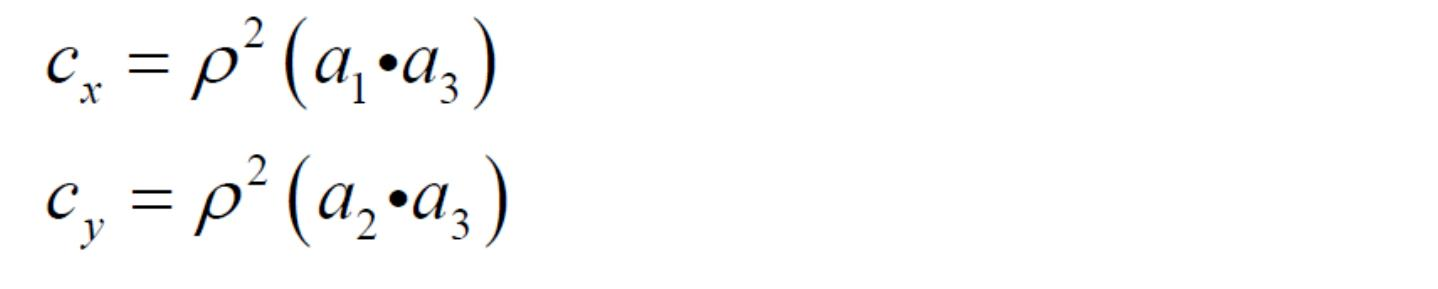

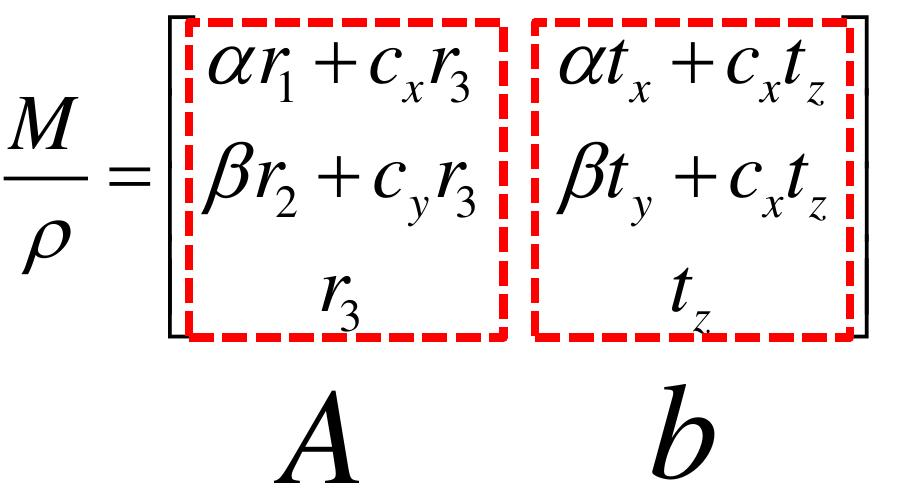

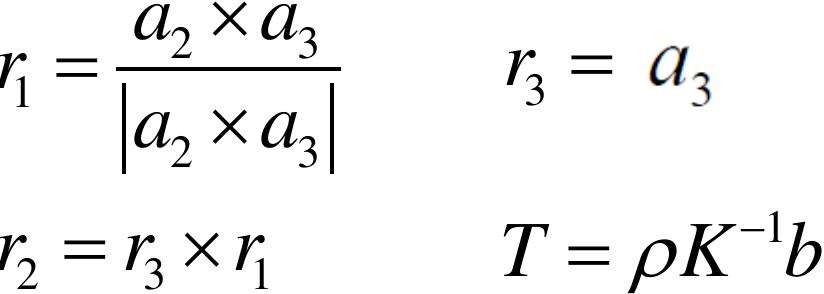

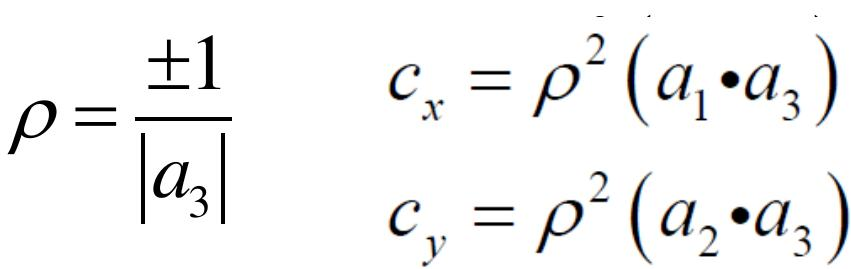

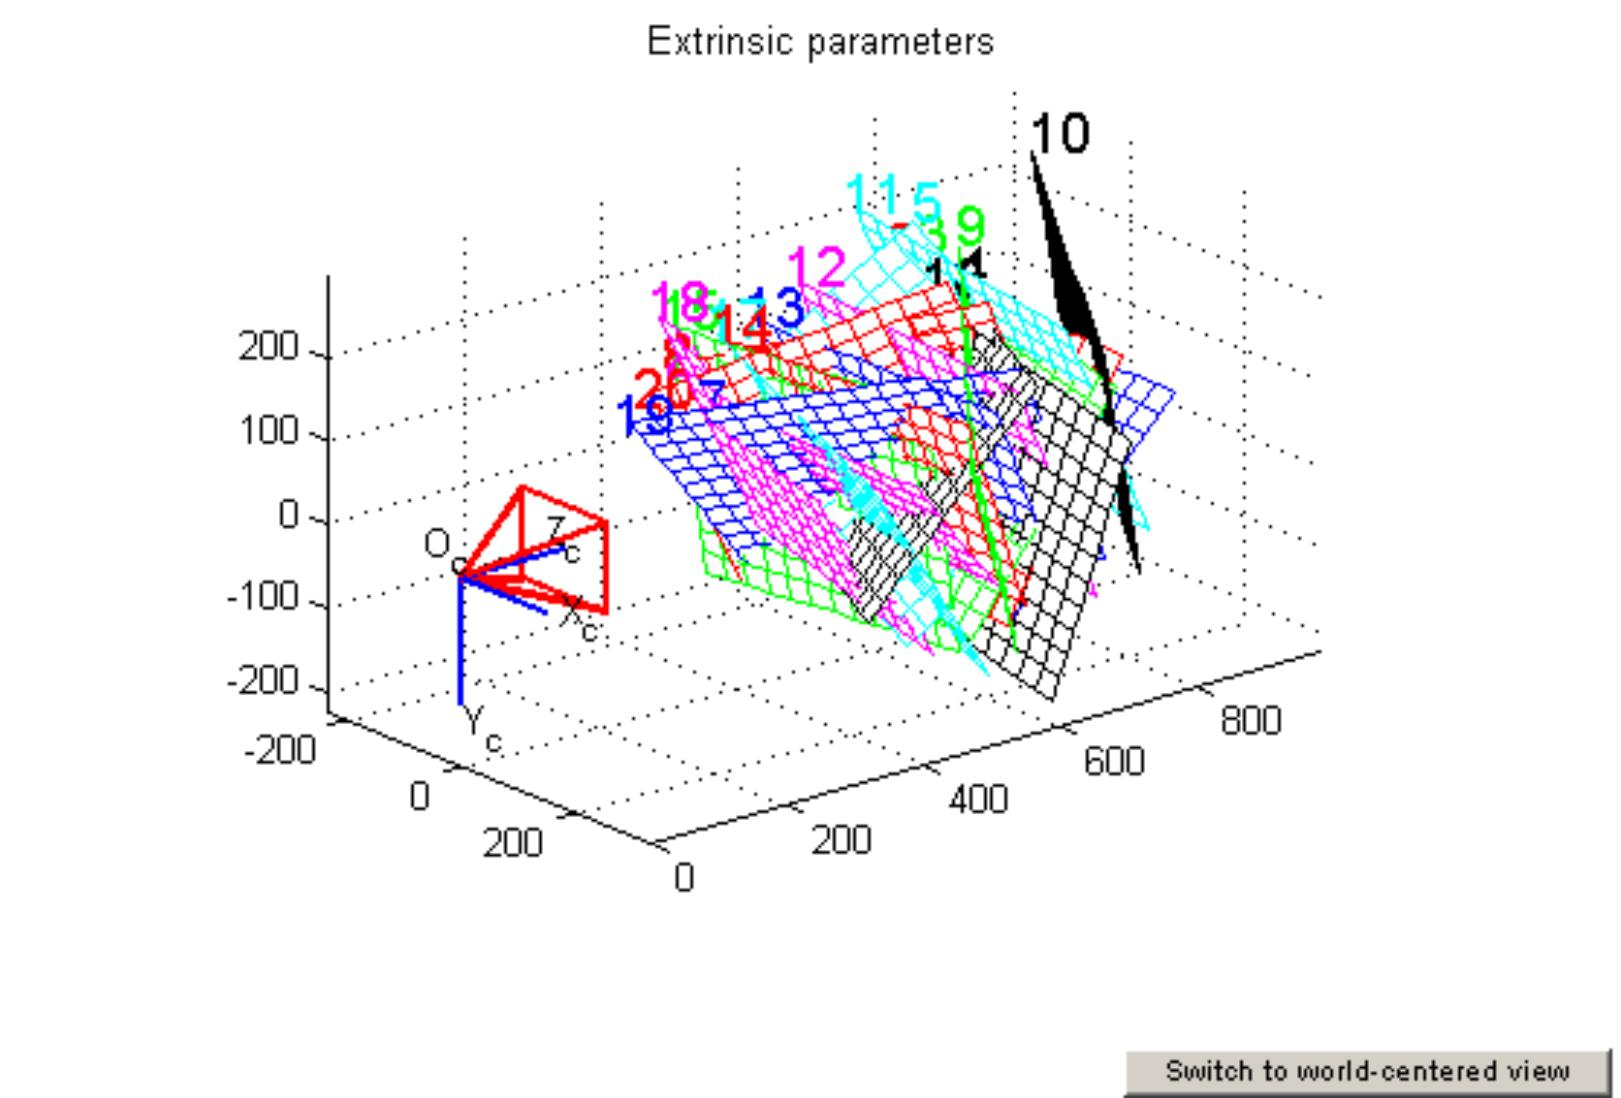

In [19]:
from IPython.display import Image, display
import glob

# Define the path to the folder containing the images
folder_path = "images/*.jpg"  # Update the file type as needed

# Use glob to search for JPG files in the specified folder
image_files = glob.glob(folder_path)

# Iterate through the list of image files and display each image inline
for image_file in image_files:
    display(Image(filename=image_file))

## Multi-modal (explain image using Llava)
#### Now, lets plugin in LangChain to explaiin the image using `Llava` via `Ollama`. More info in this [link](https://python.langchain.com/v0.1/docs/integrations/llms/ollama/)
#### [Ollama Playlist](https://www.youtube.com/playlist?list=PLz-qytj7eIWX-bpcRtvkixvo9fuejVr8y)

In [20]:
%%capture
%pip install langchain langchain_core langchain_community

In [21]:
from langchain_community.llms import Ollama

In [22]:
Ollama??

Init signature:
Ollama(
    *args: Any,
    name: Optional[str] = None,
    cache: Union[langchain_core.caches.BaseCache, bool, NoneType] = None,
    verbose: bool = None,
    callbacks: Union[List[langchain_core.callbacks.base.BaseCallbackHandler], langchain_core.callbacks.base.BaseCallbackManager, NoneType] = None,
    tags: Optional[List[str]] = None,
    metadata: Optional[Dict[str, Any]] = None,
    custom_get_token_ids: Optional[Callable[[str], List[int]]] = None,
    base_url: str = 'http://localhost:11434',
    model: str = 'llama2',
    mirostat: Optional[int] = None,
    mirostat_eta: Optional[float] = None,
    mirostat_tau: Optional[float] = None,
    num_ctx: Optional[int] = None,
    num_gpu: Optional[int] = None,
    num_thread: Optional[int] = None,
    num_predict: Optional[int] = None,
    repeat_last_n: Optional[int] = None,
    repeat_penalty: Optional[float] = None,
    temperature: Optional[float] = None,
    stop: Optional[List[str]] = None,
    tfs_z: Optional[f

In [23]:
llm = Ollama(model="llava:7b")

In [24]:
import PIL
print(PIL.__version__)

10.4.0



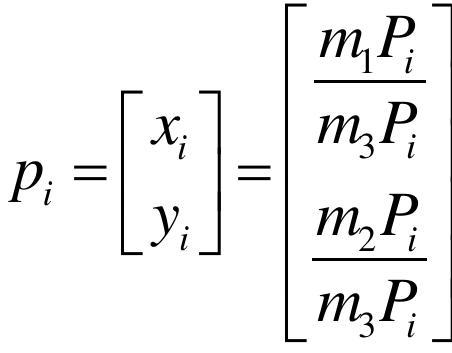

In [25]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


file_path = "/home/ameer/Kaleidoo/input-parsing/File-Data-Extraction/images/figure-8-8.jpg"
pil_image = Image.open(file_path)
image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [ ]:
llm_with_image_context = llm.bind(images=[image_b64])
llm_with_image_context.invoke("Explain the image")

In [27]:
%pip install langchain huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [28]:
from langchain.llms import HuggingFaceHub
from PIL import Image
import base64
from io import BytesIO

In [ ]:
# Use Hugging Face Hub's LLM model with image context
llm = HuggingFaceHub(repo_id="openai/clip-vit-large-patch14")
response = llm({"images": [image_b64], "prompt": "Explain the image"})

print(response)

In [30]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import base64
from io import BytesIO
import pytesseract 

# Function to convert base64 string back to PIL image
def base64_to_pil(image_b64):
    image_data = base64.b64decode(image_b64)
    image = Image.open(BytesIO(image_data))
    return image

# Load model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Convert base64 string to PIL image
pil_image = base64_to_pil(image_b64)

# Process the image and generate caption
inputs = processor(pil_image, return_tensors="pt")
out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)

print("Generated Caption:", caption)


/home/ameer/Kaleidoo/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/ameer/Kaleidoo/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated Caption: the number of the two resists is the number of the resists


In [31]:
%pip install pytesseract sympy pillow

Note: you may need to restart the kernel to use updated packages.


In [124]:
import cv2
import numpy as np

image_path = '/home/ameer/Kaleidoo/input-parsing/File-Data-Extraction/images/figure-17-23.jpg'
img = Image.open(image_path)
# Convert image to grayscale
gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
# Apply thresholding or other preprocessing techniques
_, thresh_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)

# Perform OCR on preprocessed image
processed_img = Image.fromarray(thresh_img)
extracted_text = pytesseract.image_to_string(processed_img)
print("Extracted Text from Processed Image:", extracted_text)


Extracted Text from Processed Image: 


In [125]:
# Load the image containing text


# Use Tesseract to extract text from the image
extracted_text = pytesseract.image_to_string(img)
print("Extracted Text:", extracted_text)


Extracted Text: 


In [176]:
import pytesseract
from PIL import Image
import sympy as sp

# Path to your Tesseract executable (Update this path if necessary)
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Load the image containing a math equation
image_path = '/home/ameer/Kaleidoo/input-parsing/File-Data-Extraction/images/figure-17-23.jpg'
img = Image.open(image_path)

# Use Tesseract to extract the text from the image
extracted_text = pytesseract.image_to_string(img)

print("Extracted Math Expression:", extracted_text)

# Use SymPy to solve the extracted math expression
# Ensure the extracted text is a valid equation or expression
try:
    # Convert the extracted text to a SymPy equation
    equation = sp.sympify(extracted_text)
    # Solve the equation
    solution = sp.solve(equation)

    print("Solution:", solution)
except Exception as e:
    print(f"Error solving equation: {e}")


Extracted Math Expression: 
Error solving equation: Sympify of expression 'could not parse '\x0c'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 0)


In [32]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-3.5-turbo",
)

In [40]:
# Load the image
image_path = '/home/ameer/Kaleidoo/input-parsing/File-Data-Extraction/images/figure-17-22.jpg'
img = Image.open(image_path)

# Extract text from the image
extracted_text = pytesseract.image_to_string(img)

In [41]:
extracted_text

'at, +C,t.\n+\nt\n\n \n\nMa i iis\n\nb\n\n \n\x0c'

In [34]:
prompt = f"Please describe the following mathematical expression: {extracted_text}"

In [35]:
import mimetypes

In [37]:
mime_type, _ = mimetypes.guess_type(image_path)
print("MIME Type:", mime_type)

MIME Type: image/jpeg


In [38]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{mime_type};base64,{image_b64}"},
                },
            ],
        }
    ],
)

In [39]:
print("OpenAI Response:", response.choices[0].message.content)

OpenAI Response: The mathematical expression you've posted appears to relate to a vector or matrix notation where \( p_i \) is defined as a vector consisting of two elements, \( x_i \) and \( y_i \). 

The notation is indicating that:

\[
p_i = \begin{bmatrix} x_i \\ y_i \end{bmatrix}
\]

In addition, the right side of the equation expands \( p_i \) in terms of fractions, which suggests a relationship with mass or probability distribution, as represented by the terms \( m_1 P_i, m_2 P_i, \) and \( m_3 P_i \). 

Specifically, the right-hand side forms a matrix that includes these mass-weighted probabilities or values divided by other mass components. The construction emphasizes how the vector \( p_i \) is defined based on these weighted terms.

Overall, it indicates a relationship between various quantities indexed by \( i \), which likely represents distinct entities or observations in a given context, potentially in physics, statistics, or a related field.
